In [385]:
"""
The evaluation API requires that you set up a server which will respond to inference requests.
We have already defined the server; you just need write the predict function.
When we evaluate your submission on the hidden test set the client defined in `default_gateway` will run in a different container
with direct access to the hidden test set and hand off the data timestep by timestep.

Your code will always have access to the published copies of the copmetition files.
"""

import os

import pandas as pd
import polars as pl
import numpy as np

import kaggle_evaluation.default_inference_server

train_path = "/kaggle/input/hull-tactical-market-prediction/train.csv"
test_path = "/kaggle/input/hull-tactical-market-prediction/test.csv"

train = pl.read_csv(train_path)
test_test = pl.read_csv(test_path)

print(train.columns)
print(train.shape)


['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
(9021, 98)


Step1 - Baseline model

In [386]:
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()
feature_cols = [c for c in train.columns if c.startswith(('M','E','I','P','V','S','MOM'))]
X_train = train[feature_cols].to_pandas().fillna(0)
y_train = train['market_forward_excess_returns']

def baseline_train():
    baseline_model.fit(X_train, y_train)

#baseline_train()

def baseline_predict(test: pl.DataFrame) -> pl.DataFrame:
    test_df = test.select(feature_cols).to_pandas().fillna(0)
    preds = baseline_model.predict(test_df)
    preds = np.clip(preds, 0, 2)
    preds = np.nan_to_num(preds, 0.0)

    test = test.with_columns(
        prediction = pl.Series(preds)
    )
    return test

Step2 - Model Development

Here i use LightGBM, who seems to be more useful and fast for this task and it give a better score than just the baseline

In [387]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

def lgb_train(features):
    # Select and convert to pandas
    X_train = train.select(features).to_pandas()

    # Convert all columns to float
    for col in X_train.columns:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')

    X_train = X_train.fillna(0)

    y = train["market_forward_excess_returns"].to_pandas()

    lgb_train_data = lgb.Dataset(X_train, y)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'verbose': -1
    }
    return lgb.train(params, lgb_train_data, num_boost_round=500)
    
def lgb_predict(test: pl.DataFrame, features, lgb_model):
    X_test = test.select(features).to_pandas().fillna(0)
    preds = lgb_model.predict(X_test)
    preds = np.clip(preds, 0, 2)
    return preds
 

Time series models 

scaling centered around 1 (z-score) → exploits relative variations in predictions, controls volatility.

also cap volatility to 120%

In [388]:
models = []


def lgb_train_time_series(train, feature_cols):
    min_id = int(train["date_id"].min())
    max_id = int(train["date_id"].max())

    window = 3000
    step = 500

    start = min_id
    splits = []

    while start + window <= max_id:
        train_start = start
        train_end = start + window - 1
        val_start = train_end + 1
        val_end = min(train_end + step, max_id)
        splits.append((train_start, train_end, val_start, val_end))
        start += step

    # Train a model for each split
    for train_start, train_end, val_start, val_end in splits:
        train_df = train[(train["date_id"] >= train_start) & (train["date_id"] <= train_end)]
        val_df   = train[(train["date_id"] >= val_start) & (train["date_id"] <= val_end)]

        X_train = train_df[feature_cols].fillna(0)
        y_train = train_df["market_forward_excess_returns"].fillna(0)

        X_val = val_df[feature_cols].fillna(0)
        y_val = val_df["market_forward_excess_returns"].fillna(0)

        model = lgb.LGBMRegressor(
            n_estimators=300,
            learning_rate=0.05,
            num_leaves=31
        )

        model.fit(X_train, y_train)
        models.append(model)

# cap to 120%
def cap_volatility(test: pl.DataFrame, preds):
    market_returns = test["lagged_forward_returns"].to_numpy()
    risk_free_rate = test["lagged_risk_free_rate"].to_numpy()
    market_vol = np.std(market_returns)
    strategy_returns = risk_free_rate * (1 - preds) + preds * market_returns
    strategy_vol = np.std(strategy_returns)
    max_vol = 1.2 * market_vol
    if strategy_vol > max_vol:
        scaling_factor = max_vol / strategy_vol
        preds = preds * scaling_factor
    return preds

def lgb_predict_time_series(test: pl.DataFrame, feature_cols):
    X_test = test.select(feature_cols).to_pandas().fillna(0)

    preds_all = [m.predict(X_test) for m in models]
    preds = np.mean(preds_all, axis=0)

    #scaling centered around 1 (predict allocations weight)
    mean_pred = np.mean(preds)
    std_pred = np.std(preds)
    if std_pred > 0:
        preds_scaled = 1 + (preds - mean_pred) / std_pred
    else:
        preds_scaled = np.ones_like(preds)
        
    preds_capped = cap_volatility(test, preds_scaled)
    preds_clipped = np.clip(preds_capped, 0, 2)
    
    test = test.with_columns(
        pl.Series("prediction", preds_clipped.astype(np.float32))
    )
    
    return test

step4: feature engineering

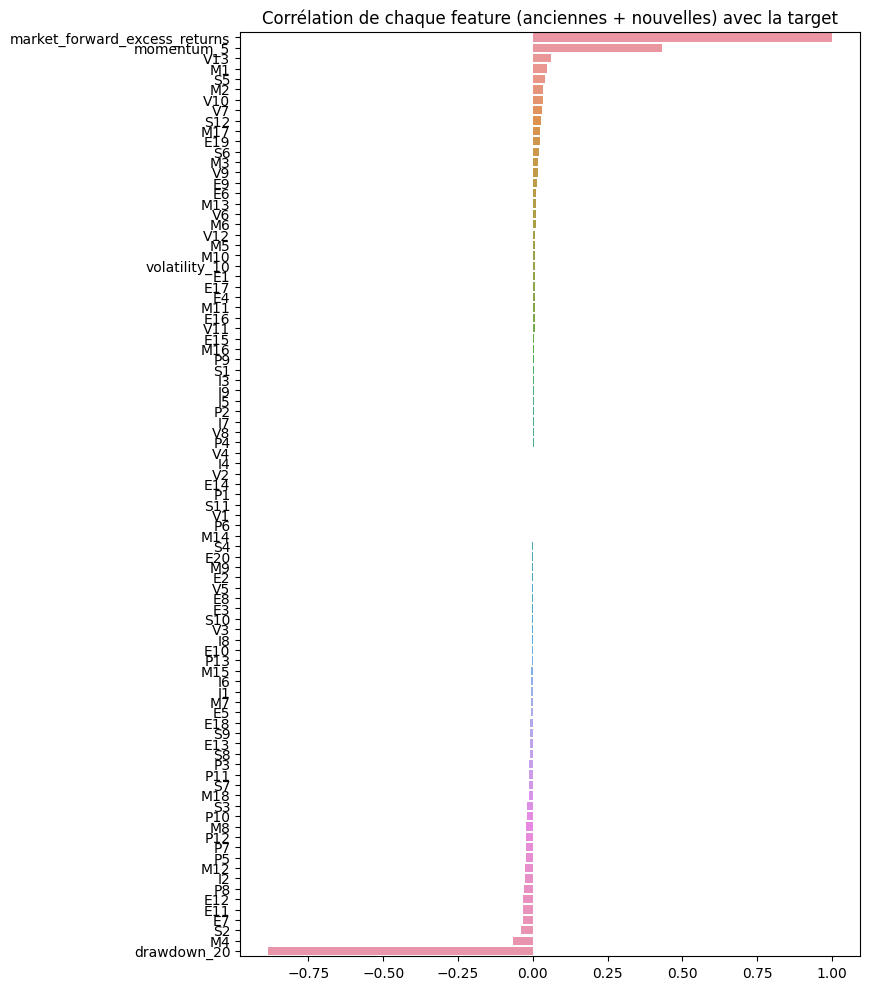

In [389]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def add_other_features(df: pl.DataFrame, is_test: bool) -> pl.DataFrame:
    col = "lagged_forward_returns" if is_test else "forward_returns"

    return (
        df
        .with_columns(
            momentum_5 = pl.col(col).rolling_mean(window_size=5, min_samples=1),
            volatility_10 = pl.col(col).rolling_std(window_size=10, min_samples=1),
            rolling_max_20 = pl.col(col).rolling_max(window_size=20, min_samples=1)
        )
        .with_columns(
            drawdown_20 = (pl.col("rolling_max_20") - pl.col(col)) / pl.col("rolling_max_20").replace(0, None)
        )
        .with_columns(
            drawdown_20 = pl.col("drawdown_20").fill_null(0)
        )
        .drop("rolling_max_20")
        )

train = add_other_features(train, is_test=False)

train_pd = train.to_pandas()

all_features = feature_cols + ["momentum_5", "volatility_10", "drawdown_20"]
corr_target = train_pd[all_features + ["market_forward_excess_returns"]] \
                .corr()["market_forward_excess_returns"] \
                .sort_values(ascending=False)

plt.figure(figsize=(8, 12))
sns.barplot(x=corr_target.values, y=corr_target.index)
plt.title("Corrélation de chaque feature (anciennes + nouvelles) avec la target")
plt.show()


In [390]:
df_corr_pl = train.select(all_features + ["market_forward_excess_returns"])
df_corr = df_corr_pl.to_pandas()

corr_target = df_corr.corr()["market_forward_excess_returns"]

seuil = 0.03

# guaranteed: only strings
selected_features = [
    str(f) for f in corr_target.index
    if abs(corr_target[f]) >= seuil and f != "market_forward_excess_returns"
]

print("features selected :", selected_features)

features selected : ['E11', 'E12', 'E7', 'M1', 'M2', 'M4', 'S2', 'S5', 'V10', 'V13', 'V7', 'momentum_5', 'drawdown_20']


In [391]:
lgb_model = lgb_train(selected_features)
#lgb_train_time_series(train, selected_features)

In [392]:
def predict(test: pl.DataFrame) -> pl.DataFrame:
    clone = test.clone()
    clone = add_other_features(clone, True)
    preds = lgb_predict(clone, selected_features, lgb_model)
    return test.with_columns(prediction=pl.Series(preds))
    #return lgb_predict_time_series(pd_to_pl(test), selected_features)

In [393]:
# When your notebook is run on the hidden test set, inference_server.serve must be called within 15 minutes of the notebook starting
# or the gateway will throw an error. If you need more than 15 minutes to load your model you can do so during the very
# first `predict` call, which does not have the usual 1 minute response deadline.
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))
